# Issue with contiguity masking Sentinel-2 at 10m resolution

## Sample query

In [1]:
import odc.algo
import datacube 
import xarray as xr
import matplotlib.pyplot as plt



dc = datacube.Datacube()

# Jervis Bay
ymax, xmin = -35.075, 150.687
ymin, xmax = -35.135, 150.712

# # Gold Coast
ymax, xmin = -28.086443, 153.445244
ymin, xmax = -28.274374, 153.598194


# Sydney
ymax, xmin = -33.825292, 151.192090
ymin, xmax = -34.014403, 151.309498


query = {
    'x': (xmin, xmax),
    'y': (ymax, ymin),
    'time': ('2018-01', '2018-12'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'fmask'],
    'output_crs': 'EPSG:32756',
    'group_by': 'solar_day'
}


In [2]:
import datacube 
from skimage.morphology import binary_opening, disk
import xarray as xr
import numpy as np

dc = datacube.Datacube()

query = {
    'x': (151.19209, 151.309498),
    'y': (-33.825292, -34.014403),
    'time': ('2018-01', '2018-03'),
    'measurements': ['fmask'],
    'output_crs': 'EPSG:32756',
    'group_by': 'solar_day',
    'resolution': (-30, 30)
}

ds = dc.load(product=['s2a_ard_granule'],
             dask_chunks={'time': 1},
             **query)



mask = (ds.fmask == 0).load()

kernel = disk(5)
mask = xr.apply_ufunc(binary_opening,
                      mask,
                      kernel.reshape((1,) + kernel.shape),
                      output_dtypes=[np.bool],
                      dask='parallelized',
                      keep_attrs=True)

<xarray.Dataset>
Dimensions:      (time: 15, x: 375, y: 707)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-10T00:02:31.026000 ... 2018-03...
  * y            (y) float64 6.256e+06 6.256e+06 ... 6.235e+06 6.235e+06
  * x            (x) float64 3.327e+05 3.327e+05 ... 3.439e+05 3.439e+05
    spatial_ref  int32 32756
Data variables:
    fmask        (time, y, x) uint8 dask.array<chunksize=(1, 707, 375), meta=np.ndarray>
Attributes:
    crs:           EPSG:32756
    grid_mapping:  spatial_ref

In [12]:
mask

<xarray.DataArray 'fmask' (time: 15, y: 707, x: 375)>
dask.array<or_, shape=(15, 707, 375), dtype=bool, chunksize=(1, 707, 375), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-01-10T00:02:31.026000 ... 2018-03...
  * y            (y) float64 6.256e+06 6.256e+06 ... 6.235e+06 6.235e+06
  * x            (x) float64 3.327e+05 3.327e+05 ... 3.439e+05 3.439e+05
    spatial_ref  int32 32756

In [13]:
from skimage.morphology import binary_opening, disk
import xarray as xr
import numpy as np

mask = (ds.fmask == 0).load()

kernel = disk(5)
mask = xr.apply_ufunc(binary_opening,
                      mask,
                      kernel.reshape((1,) + kernel.shape),
                      output_dtypes=[np.bool],
                      dask='parallelized',
                      keep_attrs=True)

## Load and preview data at 20m resolution

In [152]:
# Load data
ds = dc.load(product='s2b_ard_granule', 
             resolution=(-20, 20),
             **query)

## Create basic fmask mask

In [153]:
# ds.fmask.plot(col='time', col_wrap=4)

In [154]:
mask = odc.algo.fmask_to_bool(ds.fmask, categories=['valid', 'snow', 'water'])

In [155]:
# mask.plot(col='time', col_wrap=4)

## Create cleaned and buffered mask

In [156]:
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, disk

# def cloud_buffer(da, radius=0, base_radius=10):

#     # First remove small or narrow features using morphological closing
#     mask_closing = binary_closing(da, disk(base_radius))
    
#     # Then buffer remaining pixels by a radius to mask cloud edges
#     mask_buffer = binary_erosion(mask_closing, disk(radius))
    
#     return mask_buffer

def cloud_buffer(da, dilate_radius=15, erode_radius=5):

    # First remove small or narrow features using morphological closing
    mask_dilated = binary_dilation(da, disk(dilate_radius))
    
    # Then buffer remaining pixels by a radius to mask cloud edges
    mask_eroded = binary_erosion(mask_dilated, disk(erode_radius))
    
    return mask_eroded



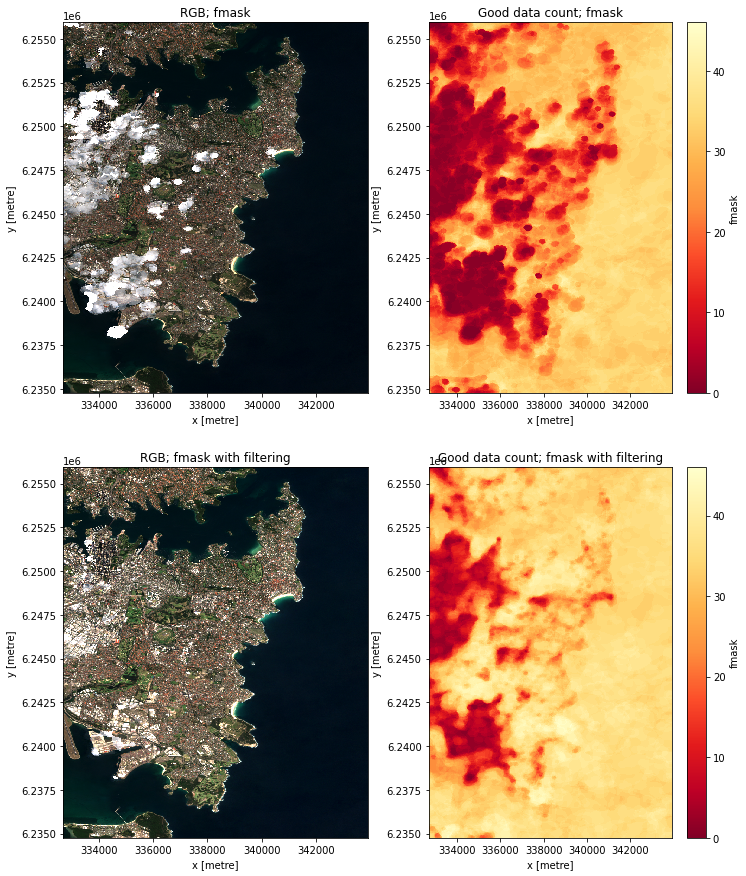

In [157]:
new_mask = mask.groupby('time').apply(cloud_buffer)
cloudy_scenes = ds.where(new_mask).nbart_blue.mean(dim=['x', 'y']) < 3000

# Compute median RGB and sum of good data through time
rgb_mask = ds.where(mask).sel(time=cloudy_scenes)[['nbart_red', 'nbart_green', 'nbart_blue']].median(dim='time')
rgb_new_mask = ds.where(new_mask).sel(time=cloudy_scenes)[['nbart_red', 'nbart_green', 'nbart_blue']].median(dim='time')
sum_mask = mask.sel(time=cloudy_scenes).sum(dim='time')
sum_new_mask = new_mask.sel(time=cloudy_scenes).sum(dim='time')


# Create four panel figure
fig, axes = plt.subplots(2, 2, figsize=(12, 15))

# Plot median RGB composites into left column
rgb_mask.to_array().plot.imshow(robust=True, ax=axes[0, 0])
rgb_new_mask.to_array().plot.imshow(robust=True, ax=axes[1, 0])

# Calculate count stats and plot count arrays into right column
vmax = xr.concat([sum_mask.max(), sum_new_mask.max()], dim='time').max().item()
sum_mask.plot(vmin=0, vmax=vmax, ax=axes[0, 1], cmap='YlOrRd_r')
sum_new_mask.plot(vmin=0, vmax=vmax, ax=axes[1, 1], cmap='YlOrRd_r')

# Set titles
axes[0, 0].set_title("RGB; fmask")
axes[0, 1].set_title("Good data count; fmask")
axes[1, 0].set_title("RGB; fmask with filtering")
axes[1, 1].set_title("Good data count; fmask with filtering");

In [158]:
from datacube.utils.cog import write_cog
write_cog(rgb_mask.to_array(), fname='test_old_mask_syd.tif')
write_cog(rgb_new_mask.to_array(), fname='test_new_mask_syd.tif')

PosixPath('test_new_mask_syd.tif')

In [117]:
# raster = xr.open_rasterio('test2.tif')
# write_cog(raster.isel(band=0), fname='raster.tif')


In [118]:
import xarray as xr
import datacube

# Connect to datacube
dc = datacube.Datacube()

# Load raster
raster = xr.open_rasterio("raster.tif").squeeze("band")

# Load data from datacube. `like=raster.geobox` step will load data
# from the datacube using the same resolution and CRS of `raster`
ds = dc.load(
    product="s2b_ard_granule",
    measurements=["nbart_red"],
    time=("2018-01", "2018-02"),
    like=raster.geobox,
    resampling="nearest",
    group_by="solar_day",
)

# Use raster data as a mask
ds.where(raster > 500)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


<xarray.Dataset>
Dimensions:      (time: 12, x: 249, y: 295)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:52:39.027000 ... 2018-02...
  * y            (y) float64 6.115e+06 6.115e+06 ... 6.109e+06 6.109e+06
  * x            (x) float64 2.886e+05 2.886e+05 ... 2.936e+05 2.936e+05
    spatial_ref  int32 32756
    band         int64 1
Data variables:
    nbart_red    (time, y, x) float64 665.0 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           +init=epsg:32756
    grid_mapping:  spatial_ref

In [ ]:
ds